Импорт библиотек

In [20]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from src.nn import BayesianBincaryClassifier

Чтение данных и разбиение на трейн и тест

In [21]:
df = pd.read_csv("Cancer_Data.csv").set_index("id")
df = df.loc[:, df.notna().all(axis=0)]
df["is_M"] = (df["diagnosis"] == "M").astype("int")
df = df.drop("diagnosis", axis=1)
x = df.drop("is_M", axis=1)
y = df["is_M"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

Обучение модели

,loss,p_item_average
epoch,,
0,4610.849609,0.000000
1,4126.989746,0.000000
2,3333.770752,0.000000
3,2838.408691,0.000000
4,2950.707031,0.000000
...,...,...
19995,0.074654,0.928064
19996,0.090998,0.913019
19997,0.065519,0.936582


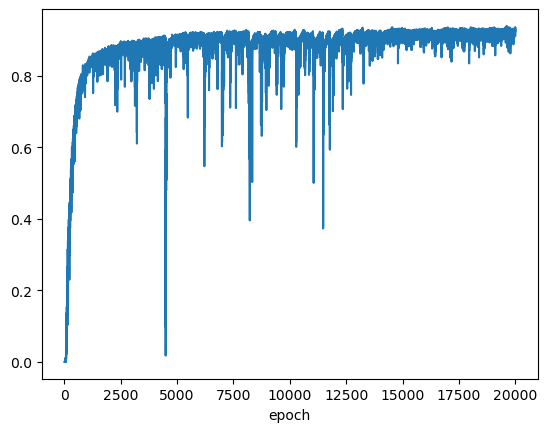

In [22]:
model = BayesianBincaryClassifier(
    dim_in=x_train.shape[-1],
    dim_hidden=10,
    n_layers=3,
    lr=0.05,
    f_act="relu",
).cuda()

x_train_tensor = torch.from_numpy(x_train.values).float().cuda()
y_train_tensor = torch.from_numpy(y_train.values).view(-1, 1).float().cuda()

model.fit(
    x=x_train_tensor,
    y=y_train_tensor,
    num_epoch=20000,
)
model.df_metrics["p_item_average"].plot()
model.df_metrics

Предсказание на тесте.
Каждый объект прогоняется через модель 5000

In [23]:
model = model.eval().cpu()
x_test_tensor = torch.from_numpy(x_test.values).float()
y_test_tensor = torch.from_numpy(y_test.values).view(-1, 1).float()

y_pred_test_tensor = torch.nn.Sigmoid()(model(x_test_tensor.expand(5000, *x_test_tensor.shape)))
y_pred_test = y_pred_test_tensor.cpu().detach().numpy()

Оценка результата работы на тесте

In [24]:
((y_pred_test.mean(axis=0).reshape(-1) > 0.5).astype("int") == y_test).sum() / len(y_test)

np.float64(0.9824561403508771)

Сравнение модели со случайным лесом

In [25]:
model_forest = RandomForestClassifier(n_estimators=500)
model_forest.fit(X=x_train, y=y_train)
y_pred_test_forest = model_forest.predict(X=x_test)

(y_pred_test_forest == y_test).sum() / len(y_test)

np.float64(0.9649122807017544)

Сравнение модели с бустингом

In [26]:
model_boost = GradientBoostingClassifier()
model_boost.fit(X=x_train, y=y_train)
y_pred_test_boost = model_boost.predict(X=x_test)

(y_pred_test_boost == y_test).sum() / len(y_test)

np.float64(0.956140350877193)

Сравнение модели с перцептроном

In [27]:
model_mlp = MLPClassifier(hidden_layer_sizes=[10, 10, 10, 10], activation="relu", max_iter=1000)
model_mlp.fit(X=x_train, y=y_train)
y_pred_test_mlp = model_mlp.predict(X=x_test)

(y_pred_test_mlp == y_test).sum() / len(y_test)

np.float64(0.9298245614035088)